In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('text', usetex=False)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 25, 
      'axes.titlesize': 25, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 18 
mpl.rcParams['ytick.labelsize'] = 18 
mpl.rcParams['legend.fontsize'] = 20

N_bootstraps = 10 ** 6

def bootstrap(control, test, N=N_bootstraps):
    """Non-parametric bootstrap"""
    concat = pd.concat([control, test])
    means = np.zeros(N)
    
    # draws:
    for n in range(N):
        shuffle = concat.sample(n=len(test), replace=True)
        means[n] = shuffle.mean()
    
    # one-tailed test:
    if test.mean() > control.mean():
        pval = (means > test.mean()).sum() / N
    else:
        pval = (means < test.mean()).sum() / N
    return pval


def get_pvals(data):
    """Dictionary of p-values"""
    pvals = {}
    for genotype in ['N2', 'pqm-1']:
        pval = bootstrap(melted.query('measured=="{0}:control"'.format(genotype)).value,
                         melted.query('measured=="{0}:ascr"'.format(genotype)).value)
        if pval == 0:
            pval = '$\leq5\cdot10^{-6}$'
            print('fixing p-value. Please make sure this fix is accurate.')
        else:
            pval = '{0:.2g}'.format(pval)

        pvals[genotype] = pval
    return pvals


def pval_plot(x1, x2, d, pval, offset=2, h=2):
    """Bars to place above boxplots with p-values"""
    # statistical annotation
    y = d.max() + offset
    col = 'k'
    plt.plot([x1, x1, x2, x2],
             [y, y + h, y + h, y],
             lw=1.5, c=col)
    

    plt.text((x1 + x2)*.5, y + h,
             "{0}".format(pval),
             ha='center', va='bottom',
             fontsize=20, color=col)

# Enlarged pharynxes in response to ascr#10 exposure 

,Area-um2
Condition,
Control,1280.565429
ascr#10,1528.463485


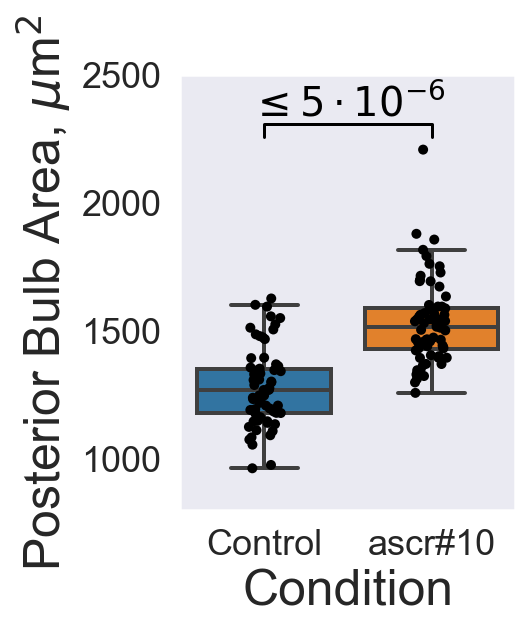

In [2]:
data = pd.read_excel('../data/assay_data/Pharynx area in um.xlsx')
pval = bootstrap(data.query('Condition=="Control"')['Area-um2'],
                 data.query('Condition=="ascr#10"')['Area-um2'])

if pval <= 5 * 10 ** -6:
    pval = '$\leq5\cdot10^{-6}$'

fig, ax = plt.subplots(figsize=(3, 4))
sns.stripplot(x='Condition', y='Area-um2', data=data, color='black', ax=ax)
sns.boxplot(x='Condition', y='Area-um2', data=data, flierprops = dict(markersize=0), ax=ax)

pval_plot(0, 1, data['Area-um2'], pval, offset=50, h=50)

plt.ylabel('Posterior Bulb Area, $\mu$m$^2$')
plt.ylim(800, 2500)

plt.savefig('../figs/area.svg', bbox_inches='tight')

data.groupby('Condition').mean()

# Increased pumping rate in response to ascr#10 exposure

KeyError: 'value'

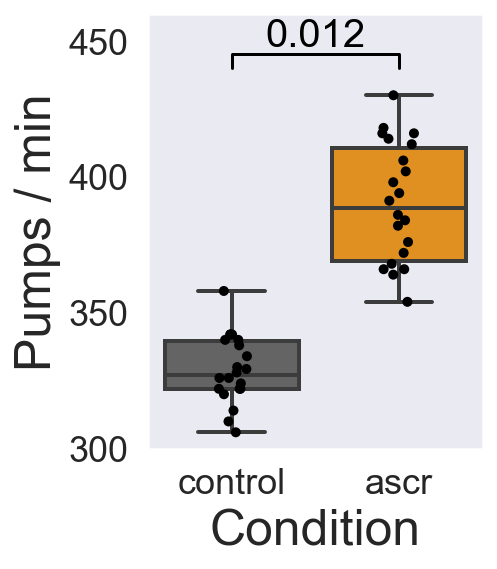

In [3]:
data = pd.read_excel('../data/assay_data/pqm1pumping.xlsx')
data = data[['pqm1control', 'pqm1ascr', 'n2control', 'n2ascr']]

data.rename(columns={'pqm1control': 'pqm-1:control',
                     'pqm1ascr': 'pqm-1:ascr',
                     'n2control': 'N2:control',
                     'n2ascr': 'N2:ascr'}, inplace=True)

## last two rows are mean and std
data.loc[:data.index.max() - 2]

melted = data.melt(var_name='measured')
melted[['Genotype', 'Condition']] = melted.measured.str.split(':', expand=True)

pvals = get_pvals(melted)

melted = melted[melted.Genotype == 'N2']

fig, ax = plt.subplots(figsize=(3, 4))
sns.stripplot(x='Condition', y='value', data=melted,
              dodge=True, color='black', ax=ax)
sns.boxplot(x='Condition', y='value', data=melted,
            palette={'control': '#646464', 'ascr': '#FF9600'},
            flierprops = dict(markersize=0), ax=ax)

pval_plot(0, 1, melted.value, pvals['N2'], offset=10, h=5)

plt.ylabel('Pumps / min')
plt.ylim(300, 460)

plt.savefig('../figs/N2_pumps.svg', bbox_inches='tight')

data.groupby('value').mean()

# Increased intestinal OP50 levels in response to ascr#10 exposure

In [ ]:
data = pd.read_excel('../data/assay_data/Quantification of OP50-GFP in Day 8 hermaphrodites.xlsx',
                     sheet_name='tidy').dropna()

mean = data.groupby(['Condition', 'Region']).mean().to_dict()

def map_control_mean(x):
    return mean['CTCF']['Control', x]

data['RefIntensity'] = data.Region.apply(map_control_mean)
data['RelativeIntensity'] = data.CTCF / data.RefIntensity

pvals = {}
for region in ['Pharynx', 'Intestine']:
    pval = bootstrap(data.query('Region=="{0}" & Condition == "Control"'.format(region)).RelativeIntensity,
                     data.query('Region=="{0}" & Condition == "ascr#10"'.format(region)).RelativeIntensity)
    if pval == 0:
        pval = '$<5\cdot10^{-4}$'
    else:
        pval = '{0:.2g}'.format(pval)

    pvals[region] = pval

fig, ax = plt.subplots(figsize=(3, 4))
sns.stripplot(x='Region', y='RelativeIntensity', hue='Condition', data=data,
              dodge=True, color='black', ax=ax)
sns.boxplot(x='Region', y='RelativeIntensity', hue='Condition', data=data,
            palette={'Control': '#646464', 'ascr#10': '#FF9600'},
            flierprops = dict(markersize=0), ax=ax)

pval_plot(-.2, .2, data.RelativeIntensity, pvals['Pharynx'], offset=.1, h=0.2)
pval_plot(.8, 1.2, data.RelativeIntensity, pvals['Intestine'], offset=.1, h=0.2)

plt.ylabel('OP50 GFP')
plt.legend([])
plt.ylim(0, 6.5)

plt.savefig('../figs/op50.svg', bbox_inches='tight')

data.groupby(['Region', 'Condition']).mean()

# Loss of *pqm-1* abrogates ascr#10-mediated effects on GPCs

In [ ]:
data = pd.read_excel('../data/assay_data/pqm1gpc.xlsx')
data = data[['pqm1control', 'pqm1ascr', 'n2control', 'n2ascr']]

data.rename(columns={'pqm1control': 'pqm-1:control',
                     'pqm1ascr': 'pqm-1:ascr',
                     'n2control': 'N2:control',
                     'n2ascr': 'N2:ascr'}, inplace=True)

data = data.loc[:data.index.max() - 5]
melted = data.melt(var_name='measured')
melted[['Genotype', 'Condition']] = melted.measured.str.split(':', expand=True)

pvals = get_pvals(melted)

fig, ax = plt.subplots(figsize=(3, 4))
sns.stripplot(x='Genotype', y='value', hue='Condition', data=melted,
              dodge=True, color='black', order=['N2', 'pqm-1'], ax=ax)
sns.boxplot(x='Genotype', y='value', hue='Condition', data=melted,
            palette={'control': '#646464', 'ascr': '#FF9600'},
            flierprops = dict(markersize=0), order=['N2', 'pqm-1'], ax=ax)

pval_plot(-.2, .2, melted.value, pvals['N2'])
pval_plot(.8, 1.2, melted.value, pvals['pqm-1'])

plt.ylabel('GPCs / gonad arm')
plt.legend(loc=(1, .3))
plt.ylim(40, 100)
plt.savefig('../figs/gpcs.svg', bbox_inches='tight')

data.groupby(['Condition', 'Genotype']).mean()

# Loss of *pqm-1* abrogates the increased pumping rate in response to ascr#10 exposure

In [ ]:
data = pd.read_excel('../data/assay_data/pqm1pumping.xlsx')
data = data[['pqm1control', 'pqm1ascr', 'n2control', 'n2ascr']]

data.rename(columns={'pqm1control': 'pqm-1:control',
                     'pqm1ascr': 'pqm-1:ascr',
                     'n2control': 'N2:control',
                     'n2ascr': 'N2:ascr'}, inplace=True)

## last two rows are mean and std
data.loc[:data.index.max() - 2]

melted = data.melt(var_name='measured')
melted[['Genotype', 'Condition']] = melted.measured.str.split(':', expand=True)

pvals = get_pvals(melted)


sns.stripplot(x='Genotype', y='value', hue='Condition', data=melted,
              order=['N2', 'pqm-1'],
              dodge=True, color='black')
sns.boxplot(x='Genotype', y='value', hue='Condition', data=melted,
            palette={'control': '#646464', 'ascr': '#FF9600'},
            order=['N2', 'pqm-1'],
            flierprops = dict(markersize=0))

pval_plot(-.2, .2, melted.value, pvals['N2'], offset=10)
pval_plot(.8, 1.2, melted.value, pvals['pqm-1'], offset=10)

plt.ylabel('Pumps / min')
plt.legend(loc=(1, .3))
plt.ylim(300, 460)

data.groupby(['Genotype', 'Condition']).mean()

In [ ]:
melted = melted[melted.Genotype == 'pqm-1']

fig, ax = plt.subplots(figsize=(3, 4))
sns.stripplot(x='Condition', y='value', data=melted,
              dodge=True, color='black', ax=ax)
sns.boxplot(x='Condition', y='value', data=melted,
            palette={'control': '#646464', 'ascr': '#FF9600'},
            flierprops = dict(markersize=0), ax=ax)

pval_plot(0, 1, melted.value, pvals['pqm-1'], offset=1, h=5)

plt.ylabel('Pumps / min')
plt.legend(loc=(1, .3))
plt.ylim(300, 370)
plt.savefig('../figs/pumps-pqm1.svg', bbox_inches='tight')

# Loss of *pqm-1* abrogates ascr#10-mediated roaming behaviors

In [ ]:
data = pd.read_excel('../data/assay_data/pqm1roam2.xlsx')
data = data[['pqmcontrol', 'pqmascr', 'N2control', 'N2ascr']]

data.rename(columns={'pqmcontrol': 'pqm-1:control',
                     'pqmascr': 'pqm-1:ascr',
                     'N2control': 'N2:control',
                     'N2ascr': 'N2:ascr'}, inplace=True)

melted = data.melt(var_name='measured')
melted[['Genotype', 'Condition']] = melted.measured.str.split(':', expand=True)

pvals = get_pvals(melted)

melted.sort_values(['Genotype', 'Condition'], ascending=[True, False], inplace=True)

fig, ax = plt.subplots(figsize=(3, 4))
sns.stripplot(x='Genotype', y='value', hue='Condition', data=melted,
              order=['N2', 'pqm-1'], ax=ax,
              dodge=True, color='black')
sns.boxplot(x='Genotype', y='value', hue='Condition', data=melted,
            palette={'control': '#646464', 'ascr': '#FF9600'},
            order=['N2', 'pqm-1'], ax=ax,
            flierprops = dict(markersize=0))

pval_plot(-.2, .2, melted.value, pvals['N2'])
pval_plot(.8, 1.2, melted.value, pvals['pqm-1'])

plt.ylabel('Squares entered')
plt.legend(loc=(1, .3))
plt.ylim(10, 80)
plt.savefig('../figs/squares-pqm1.svg', bbox_inches='tight')

data.groupby(['Genotype', 'Condition']).mean()